In [1]:
# Library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import statsmodels.formula.api as smf

# Exploring Accidents

The only information source for car accidents data comes from the data collected by AUSA.<br>
AUSA is a private company that is currently the licencee for the only highway in the city of Buenos Aires.

In [2]:
path = os.path.join(os.path.dirname(os.getcwd()), 'raw_data', 'Accidentes')

os.listdir(path)

['reclamos-ausa.csv',
 'documentacion-seguridad-vial.pdf',
 '.ipynb_checkpoints',
 'intervenciones-de-seguridad-vial.csv']

Two datasets composed by highway claims and interventions from security staff on highway.

# Highway Claims

Opening claims dataframe.

In [3]:
claims = pd.read_csv(os.path.join(path, 'reclamos-ausa.csv'))
claims.head()

,nro_caso,titulo_caso,fecha
0,C00126163,RECLAMOS/VUELTO ERRONEO/FALTANTE,2016-12-01 15:47:26
1,C00126165,RECLAMOS/DAÑO DEL VEHICULO SOBRE AU./OBJETO,2016-12-01 16:01:31
2,C00126167,RECLAMOS/DAÑO EN VIA DE PEAJE/VÍA 07 A,2016-12-01 16:13:41
3,C00126169,RECLAMOS/DAÑO DEL VEHICULO SOBRE AU./AGRESIÓN ...,2016-12-01 16:35:22
4,C00126171,QUEJAS/TELEPEAJE/DISPOSICIONES DE SERVICIO,2016-12-01 17:15:12


Claims dataset has 3 features:


- `nro_caso` case number or case ID
- `titulo_caso` case title
- `fecha` date

In [4]:
claims.titulo_caso[0].split('/')

['RECLAMOS', 'VUELTO ERRONEO', 'FALTANTE']

A closer look to `titulo_caso` column shows us that it's composed of three parts that we could call: `category`, `subcategory` and `description`.  

We'll create new features for better comprehension of the data.

In [5]:
# Lists to be populated during loop
categories = []
subcategories = []
descriptions = []

for claim in claims.titulo_caso:
    # Dividing information
    category = claim.split('/')[0]
    subcategory = claim.split('/')[1]
    description = claim.split('/')[2]
    # Inserting information into lists
    categories.append(category)
    subcategories.append(subcategory)
    descriptions.append(description)

# New features
claims['category'] = categories
claims['subcategory'] = subcategories
claims['description'] = descriptions

With the new features created there's no need to keep the original column nor the `nro_caso` column as it doesn't provide any information either.

In [6]:
claims.drop(columns=['nro_caso', 'titulo_caso'], inplace=True)

Let's take a look at the dataset now:

In [7]:
claims.columns = ['date', 'category', 'subcategory', 'description']

claims.head()

,date,category,subcategory,description
0,2016-12-01 15:47:26,RECLAMOS,VUELTO ERRONEO,FALTANTE
1,2016-12-01 16:01:31,RECLAMOS,DAÑO DEL VEHICULO SOBRE AU.,OBJETO
2,2016-12-01 16:13:41,RECLAMOS,DAÑO EN VIA DE PEAJE,VÍA 07 A
3,2016-12-01 16:35:22,RECLAMOS,DAÑO DEL VEHICULO SOBRE AU.,AGRESIÓN POR TERCEROS
4,2016-12-01 17:15:12,QUEJAS,TELEPEAJE,DISPOSICIONES DE SERVICIO


In [8]:
claims.tail()

,date,category,subcategory,description
5654,2019-04-20 10:00:21,QUEJAS,MALA ATENCION,A completar
5655,2019-04-20 15:00:24,QUEJAS,EN GENERAL,A completar
5656,2019-04-22 11:00:24,RECLAMOS,VUELTO ERRONEO,A completar
5657,2019-04-23 10:30:10,QUEJAS,PEAJE,A completar
5658,2019-04-23 10:30:20,QUEJAS,EN GENERAL,A completar


For data consistency let's ensure everything is in *uppercase* and with no trailing whitespaces. 

In [9]:
for feature in claims:
    claims[feature] = claims[feature].str.upper().str.strip()

Let's explore the `category` feature:

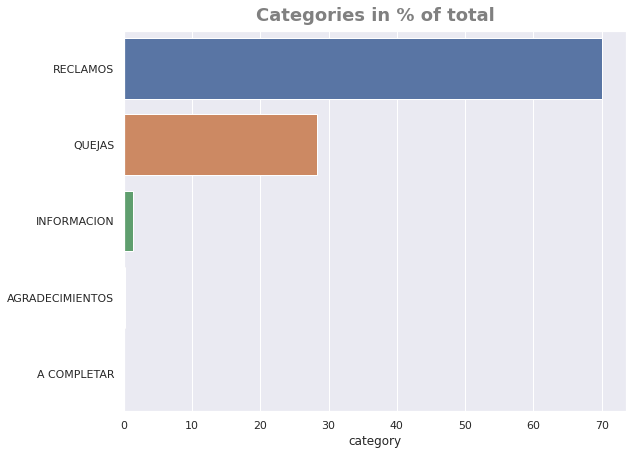

In [10]:
sns.set_theme()
plt.figure(figsize=(9,7))
plt.title('Categories in % of total', loc = 'center', size = 18, 
                pad = 10, fontweight = 'bold', color = 'gray')
ax = sns.barplot(y=claims.category.value_counts().index, x=claims.category.value_counts(normalize=True) * 100);

We can easily see that `RECLAMOS` with 70% (ie. "Demands") and `QUEJAS` with ~30% (ie. "Complaints") are the most frecuent categories.

We'll analize them separetly to get more details. 

First, we'll get into `RECLAMOS` and create a `demands` dataframe to use.

In [11]:
demands = claims[claims.category == 'RECLAMOS'].drop(columns = ['category'])
len(demands)

3965

Top 5 subcategories are almost 98% of the total demands, so let's focus on them.

In [12]:
round(demands.subcategory.value_counts().head().sum() / len(demands) *100, 2)

97.55

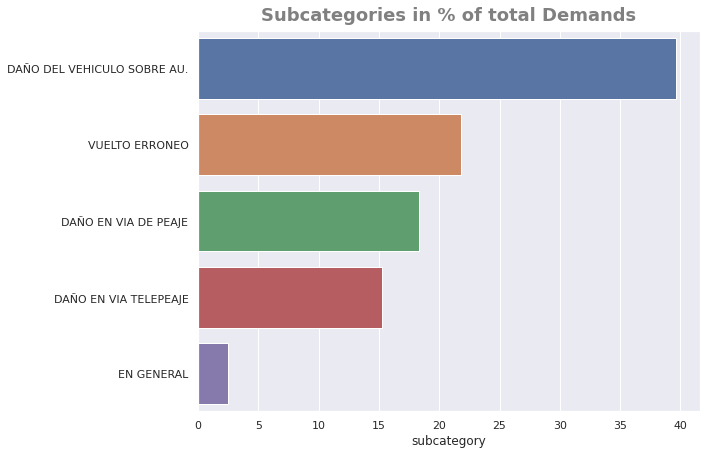

In [13]:
plt.figure(figsize=(9,7))
plt.title('Subcategories in % of total Demands', loc = 'center', size = 18, 
                pad = 10, fontweight = 'bold', color = 'gray')

sns.barplot(y=demands.subcategory.value_counts().head().index,
            x=demands.subcategory.value_counts(normalize=True).head()*100);

In [14]:
round(len(demands[demands.subcategory.str.contains('DAÑO')]) / len(demands) *100, 2)

73.32

So a little bit over 70% of the `demands` are related to `damages` ("*DAÑO..*").

Let's inspect these `damages` to see if we can get some insights.

In [15]:
print(f"""Number of possible explanations for damages: 
{demands[demands.subcategory.str.contains('DAÑO')].description.nunique()}""")

Number of possible explanations for damages: 
125


As we could imagine, there's a lot of possible explanations to these `damages`. 

Let's see if we could narrow them up using a Pareto approach:

20% of 125 is 25, so let's see how much the top 25 explanations impact on the total.

In [16]:
print(f"""Percentage of damages explained by top 20% features:
{demands[demands.subcategory.str.contains('DAÑO')].description.value_counts().head(25).sum() /
len(demands[demands.subcategory.str.contains('DAÑO')]) *100}""")

Percentage of damages explained by top 20% features:
79.32576539387685


🙌🏽 

So that's a happy coincidence 😅

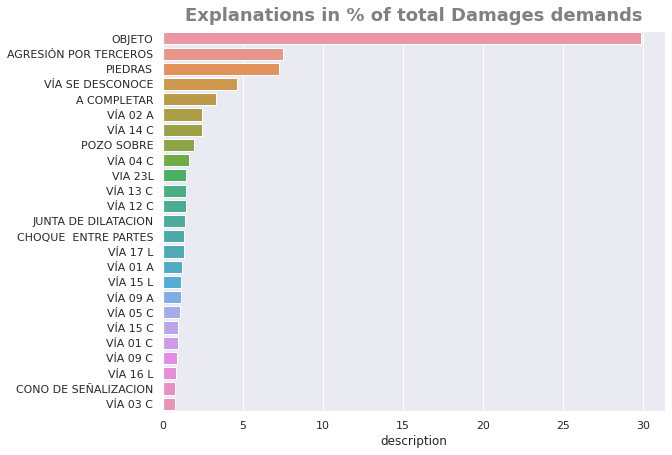

In [17]:
x = demands[demands.subcategory.str.contains('DAÑO')].description.value_counts(normalize=True).head(25) * 100
y = demands[demands.subcategory.str.contains('DAÑO')].description.value_counts(normalize=True).head(25).index

plt.figure(figsize=(9,7))
plt.title('Explanations in % of total Damages demands', loc = 'center', size = 18, 
                pad = 10, fontweight = 'bold', color = 'gray')
sns.barplot(y=y, x=x);

In [18]:
claims[claims.category == 'QUEJAS'].subcategory.value_counts().head().sum() / len(claims[claims.category == 'QUEJAS'])

0.8770287141073658

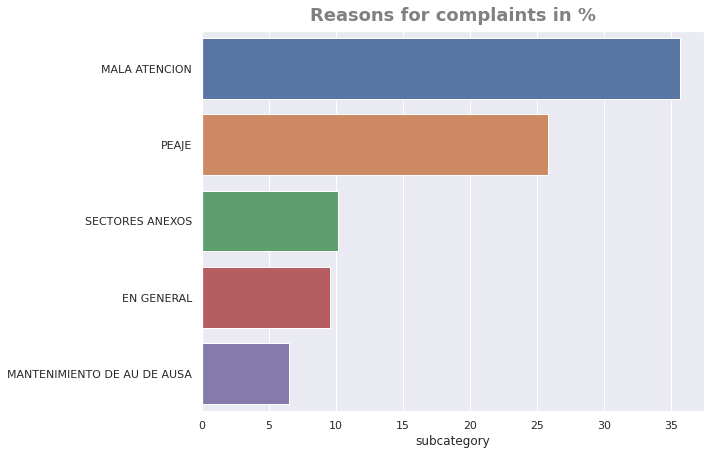

In [19]:
x = claims[claims.category == 'QUEJAS'].subcategory.value_counts(normalize=True).head() * 100
y = claims[claims.category == 'QUEJAS'].subcategory.value_counts().head().index

plt.figure(figsize=(9,7))
plt.title('Reasons for complaints in %', loc = 'center', size = 18, 
                pad = 10, fontweight = 'bold', color = 'gray')
sns.barplot(y=y, x=x);

# Accident Reports

Opening accident reports dataset.

In [20]:
accidents = pd.read_csv(os.path.join(path, 'intervenciones-de-seguridad-vial.csv'))
accidents.head()

,periodo,fecha,hora,autopista,banda_y_o_ramal,pk,condiciones_meteorologicas,superficie_de_la_via,lesionados,fallecidos,tipo_de_siniestro,moto,liviano,bus,camion
0,201401,2014-01-01,1,AU CAMPORA,ASCENDENTE,600,BUENO,SECA,1,0,COLISION CON OBSTACULO FIJO,0,1,0,0
1,201401,2014-01-01,3,AU DELLEPIANE,DESCENDENTE,600,BUENO,SECA,0,0,COLISION CON OBSTACULO FIJO,0,1,0,0
2,201401,2014-01-01,22,AU 25 DE MAYO,ASCENDENTE,5900,BUENO,SECA,8,0,COLISION CON DOS O MAS VEHICULOS,0,2,0,0
3,201401,2014-03-01,7,AU CAMPORA,DESCENDENTE,600,BUENO,SECA,0,0,OBSTACULO NO FIJO,0,0,0,1
4,201401,2014-03-01,21,AU PERTIO MORENO,DESCENDENTE,5400,BUENO,SECA,1,0,COLISION CON OBSTACULO FIJO,0,2,0,0


✅ No null values

In [21]:
accidents.isna().sum()

periodo                       0
fecha                         0
hora                          0
autopista                     0
banda_y_o_ramal               0
pk                            0
condiciones_meteorologicas    0
superficie_de_la_via          0
lesionados                    0
fallecidos                    0
tipo_de_siniestro             0
moto                          0
liviano                       0
bus                           0
camion                        0
dtype: int64

We'll have to convert `fecha` into datetime format.

In [22]:
accidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6962 entries, 0 to 6961
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   periodo                     6962 non-null   int64 
 1   fecha                       6962 non-null   object
 2   hora                        6962 non-null   int64 
 3   autopista                   6962 non-null   object
 4   banda_y_o_ramal             6962 non-null   object
 5   pk                          6962 non-null   object
 6   condiciones_meteorologicas  6962 non-null   object
 7   superficie_de_la_via        6962 non-null   object
 8   lesionados                  6962 non-null   int64 
 9   fallecidos                  6962 non-null   int64 
 10  tipo_de_siniestro           6962 non-null   object
 11  moto                        6962 non-null   int64 
 12  liviano                     6962 non-null   int64 
 13  bus                         6962 non-null   int6

Specific dates have mixed formatting (uses '-' and '/' as separators), so that implies a bit of preprocessing for it to be useful

In [23]:
accidents.fecha.unique()

array(['2014-01-01', '2014-03-01', '2014-04-01', ..., '25/02/2021',
       '26/02/2021', '28/02/2021'], dtype=object)

In [24]:
accidents.fecha = pd.to_datetime(accidents.fecha)
accidents.fecha.unique()

array(['2014-01-01T00:00:00.000000000', '2014-03-01T00:00:00.000000000',
       '2014-04-01T00:00:00.000000000', ...,
       '2021-02-25T00:00:00.000000000', '2021-02-26T00:00:00.000000000',
       '2021-02-28T00:00:00.000000000'], dtype='datetime64[ns]')

We have data for 2021 which could generate some noise in the aggregate as it's not a complete year.

We'll drop for consistency.

In [25]:
accidents.drop(index=accidents[accidents.fecha.dt.year == 2021].index, inplace=True)

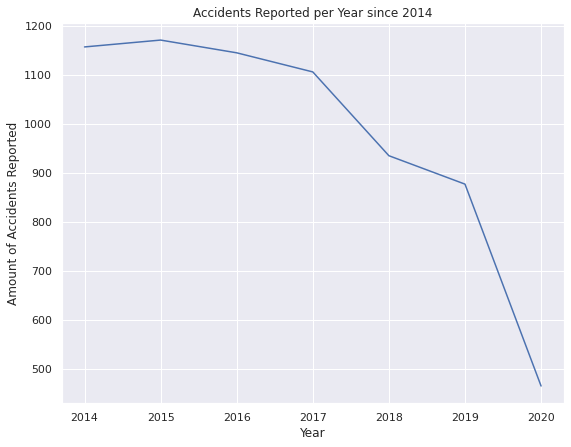

In [26]:
plt.figure(figsize=(9,7))
plt.plot(accidents.groupby(accidents.fecha.dt.year)['periodo'].count())
plt.xlabel('Year')
plt.ylabel('Amount of Accidents Reported')
plt.title('Accidents Reported per Year since 2014');

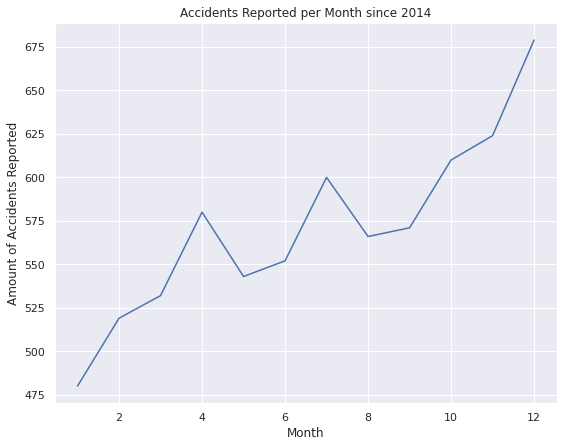

In [27]:
plt.figure(figsize=(9,7))
plt.plot(accidents.groupby(accidents.fecha.dt.month)['periodo'].count())
plt.xlabel('Month')
plt.ylabel('Amount of Accidents Reported')
plt.title('Accidents Reported per Month since 2014');

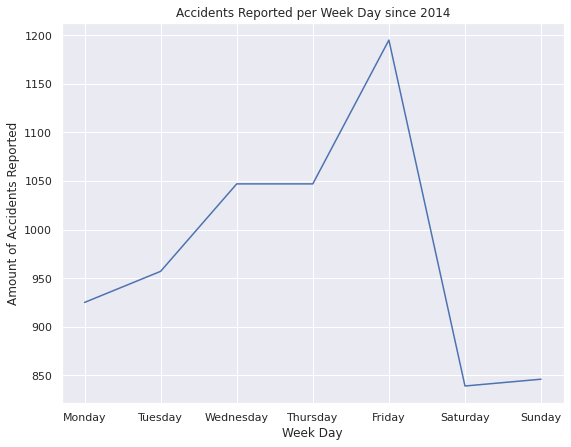

In [28]:
week_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] 
plt.figure(figsize=(9,7))
plt.plot(week_days, accidents.groupby(accidents.fecha.dt.weekday)['periodo'].count())
plt.xlabel('Week Day')
plt.ylabel('Amount of Accidents Reported')
plt.title('Accidents Reported per Week Day since 2014');

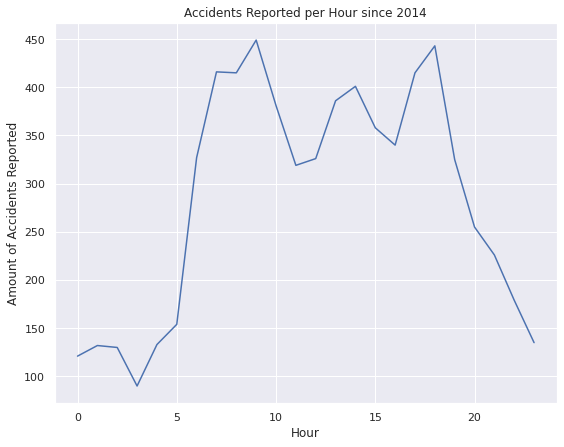

In [29]:
plt.figure(figsize=(9,7))
plt.plot(accidents.groupby(accidents.hora)['periodo'].count())
plt.xlabel('Hour')
plt.ylabel('Amount of Accidents Reported')
plt.title('Accidents Reported per Hour since 2014');

In [30]:
accidents.columns

Index(['periodo', 'fecha', 'hora', 'autopista', 'banda_y_o_ramal', 'pk',
       'condiciones_meteorologicas', 'superficie_de_la_via', 'lesionados',
       'fallecidos', 'tipo_de_siniestro', 'moto', 'liviano', 'bus', 'camion'],
      dtype='object')

In [31]:
accidents['dia'] = accidents.fecha.dt.weekday

In [32]:
accidents.fallecidos.value_counts()

0    6800
1      55
2       1
Name: fallecidos, dtype: int64

In [33]:
accidents.drop(accidents[accidents.fallecidos == 2].index, inplace=True)

In [34]:
accidents.fallecidos.value_counts()

0    6800
1      55
Name: fallecidos, dtype: int64

In [35]:
accidents.superficie_de_la_via.value_counts()

SECA             5746
MOJADA/HUMEDA    1092
OTRO               15
<SD>                1
INUNDADA            1
Name: superficie_de_la_via, dtype: int64

In [36]:
accidents.drop(accidents[(accidents.superficie_de_la_via == '<SD>') |
                         (accidents.superficie_de_la_via == 'INUNDADA')].index, inplace=True)

In [37]:
accidents.condiciones_meteorologicas.value_counts()

BUENO                   5980
LLUVIOSO                 860
NIEBLA, BRUMA O HUMO       9
VIENTOS FUERTES            3
NIEBLA                     1
Name: condiciones_meteorologicas, dtype: int64

In [38]:
accidents.drop(accidents[(accidents.condiciones_meteorologicas == 'NIEBLA') |
(accidents.condiciones_meteorologicas == 'VIENTOS FUERTES')].index, inplace=True)

In [82]:
fallecidos = smf.mnlogit(formula='''fallecidos ~ moto + liviano + bus + camion + dia + hora 
                         + C(superficie_de_la_via) - 1''',
                         data=accidents).fit(maxiter=50)
fallecidos.summary()

         Current function value: 0.042104
         Iterations: 50


/home/tomas/.pyenv/versions/3.8.6/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:             fallecidos   No. Observations:                 6849
Model:                        MNLogit   Df Residuals:                     6840
Method:                           MLE   Df Model:                            8
Date:                Wed, 21 Apr 2021   Pseudo R-squ.:                 0.09920
Time:                        18:37:54   Log-Likelihood:                -288.37
converged:                      False   LL-Null:                       -320.13
Covariance Type:            nonrobust   LLR p-value:                 9.478e-11
==========================================================================================================
                          fallecidos=1       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
C(superficie_de_la_via)[MOJADA/HUMEDA]    -5.3538      0.616     -8.694      0.000      -6.561      -4.147
C(superficie_de_la_via)[OTRO]            -15.8072    377.161     -0.042      0.967    -755.030     723.416
C(superficie_de_la_via)[SECA]             -5.4380      0.540    -10.074      0.000      -6.496      -4.380
moto                                       1.0596      0.249      4.253      0.000       0.571       1.548
liviano                                   -0.4986      0.219     -2.276      0.023      -0.928      -0.069
bus                                        0.9538      0.447      2.133      0.033       0.077       1.830
camion                                     1.1091      0.210      5.275      0.000       0.697       1.521
dia                                        0.0824      0.075      1.092      0.275      -0.065       0.230
hora                                      -0.0157      0.026     -0.605      0.545      -0.067       0.035
==========================================================================================================
"""

In [75]:
fallecidos.summary?

In [53]:
fallecidos.params.index

Index(['Intercept', 'C(superficie_de_la_via)[T.OTRO]',
       'C(superficie_de_la_via)[T.SECA]',
       'C(condiciones_meteorologicas)[T.LLUVIOSO]',
       'C(condiciones_meteorologicas)[T.NIEBLA, BRUMA O HUMO]', 'moto',
       'liviano', 'bus', 'camion', 'dia', 'hora'],
      dtype='object')